# IMPORTING LIBRARIES/ READ OUR DATASET

In [1]:
# TODO: Take out the entities for each class and study which people are being more targetted
# TODO: Add confusion matrix to classifier chosen

In [94]:
import pandas as pd
import numpy as np

import re
from string import punctuation
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer

import matplotlib.pyplot as plt
import seaborn as sns


from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split

from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.calibration import CalibratedClassifierCV
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

from sklearn.metrics import (confusion_matrix,
                             precision_recall_curve,
                             classification_report,
                             roc_auc_score,
                             accuracy_score,
                             precision_score,
                             recall_score,
                             f1_score,
                             roc_curve,
                             auc)

import time
from pathlib import Path
import os
import joblib
from collections import defaultdict

import warnings
warnings.filterwarnings('ignore')

In [95]:
# # download Datasets
# ! kaggle competitions download -c fake-news
# ! unzip fake-news.zip -d Database
# ! rm fake-news.zip

---
**Project Objective:**

Our objective is to predict if the news are reliable or trying to spread missinformation. <br/>
<br/>
Labels: <br/>
&emsp;0: reliable  <br/>
&emsp;1: unreliable  <br/>

---

In [96]:
data = pd.read_csv(r'Database/train.csv')[['title', 'author', 'label']]

In [97]:
data

,title,author,label
0,House Dem Aide: We Didn’t Even See Comey’s Let...,Darrell Lucus,1
1,"FLYNN: Hillary Clinton, Big Woman on Campus - ...",Daniel J. Flynn,0
2,Why the Truth Might Get You Fired,Consortiumnews.com,1
3,15 Civilians Killed In Single US Airstrike Hav...,Jessica Purkiss,1
4,Iranian woman jailed for fictional unpublished...,Howard Portnoy,1
...,...,...,...
20795,Rapper T.I.: Trump a ’Poster Child For White S...,Jerome Hudson,0
20796,"N.F.L. Playoffs: Schedule, Matchups and Odds -...",Benjamin Hoffman,0
20797,Macy’s Is Said to Receive Takeover Approach by...,Michael J. de la Merced and Rachel Abrams,0
20798,"NATO, Russia To Hold Parallel Exercises In Bal...",Alex Ansary,1


# EDA: Exploratory Data Analysis

In [98]:
# we seem to have some nulls
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20800 entries, 0 to 20799
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   title   20242 non-null  object
 1   author  18843 non-null  object
 2   label   20800 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 487.6+ KB


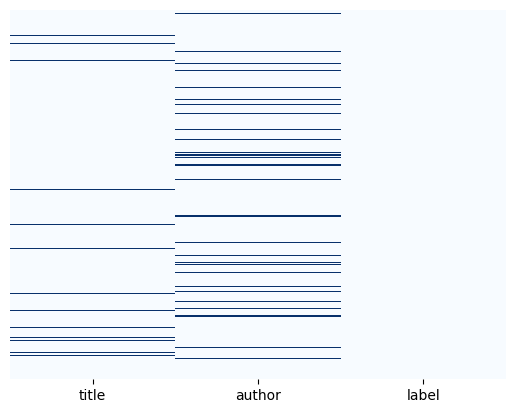

In [99]:
# let's visualize our null values
sns.heatmap(data.isnull(), yticklabels=False, cbar=False, cmap='Blues')
plt.show()

In [100]:
# okay so 99% of the time the author is null it comes from an unreliable source
data[data['author'].isna()].value_counts(subset='label', normalize= True)

label
1    0.986714
0    0.013286
dtype: float64

In [101]:
# every time the title is null it's an unreliable source
data[data['title'].isna()].value_counts(subset='label', normalize= True)

label
1    1.0
dtype: float64

In [102]:
data.fillna({'title': 'no title', 'author': 'no author'}, inplace=True)

Note: Since every time we have a missing value it a news spreading missinformation we want our model to learn that pattern so we will fill them

In [103]:
# okay we have duplicates
data.describe(include=['O'])

,title,author
count,20800,20800
unique,19804,4202
top,no title,no author
freq,558,1957


In [104]:
# we have 388 duplicates
data.duplicated().sum()

388

In [105]:
# let's visualize them
data[data.duplicated()].sort_values('author')

,title,author,label
15946,Gingrich slut-shames Megyn Kelly,-NO AUTHOR-,1
12780,"Obamacare tax penalty? I'll take it, millions say",-NO AUTHOR-,1
7730,"Ex-rep: 'If Trump loses, I'm grabbing my musket'",-NO AUTHOR-,1
11945,"Feds: 275,000 born to illegals in 1 year",-NO AUTHOR-,1
13219,"Kenyan refugee kills co-worker, self",-NO AUTHOR-,1
...,...,...,...
11410,no title,parum imperium,1
15326,no title,plumpplumberbalding,1
16526,no title,plumpplumberbalding,1
20431,The Mothers,stclair,1


In [106]:
# Let's drop them
data.drop_duplicates(inplace=True)
# check if we have removed them
data.duplicated().sum()

0

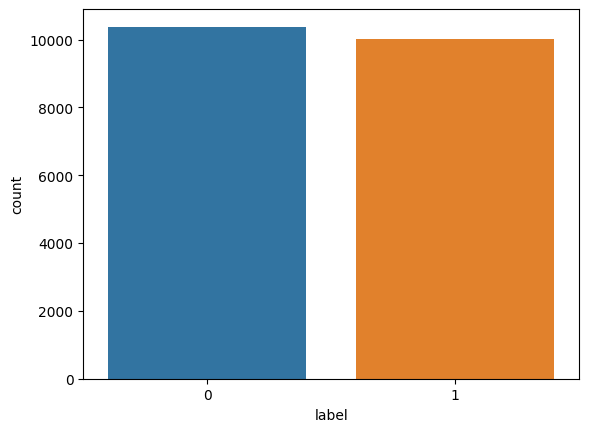

In [107]:
# Let's visualize our label distribution now that our dataset has been treated
# we have a pretty balanced dataset
sns.countplot(x = data['label'])
plt.show()

In [108]:
# since having a null author is a indicator that it comes from an unreliable source
# let's look which author are the most reliable, we might see them again in our models explanability
authors = data.pivot_table(index='author', columns='label', aggfunc='size', fill_value=0).reset_index()
authors.columns = ['author', 'reliable', 'unreliable']

In [109]:
# most reliable authors
authors.sort_values('reliable', ascending= False)

,author,reliable,unreliable
2944,Pam Key,242,1
1762,Jerome Hudson,166,0
724,Charlie Spiering,141,0
1857,John Hayward,140,0
2090,Katherine Rodriguez,124,0
...,...,...,...
1782,Jhayla Walls,0,1
1783,Jim,0,1
1784,Jim Davis,0,1
1787,Jim Hightower,0,1


In [110]:
# most unreliable authors
authors.sort_values('unreliable', ascending= False)

,author,reliable,unreliable
4079,no author,26,1896
3929,admin,0,192
2939,Pakalert,0,85
1111,Eddy Lavine,0,85
3518,Starkman,0,84
...,...,...,...
2490,Matt Richtel and Andrew Pollack,1,0
2491,Matt Stevens,1,0
1049,Dionne Searcey,5,0
2493,Matthew Boyle,33,0


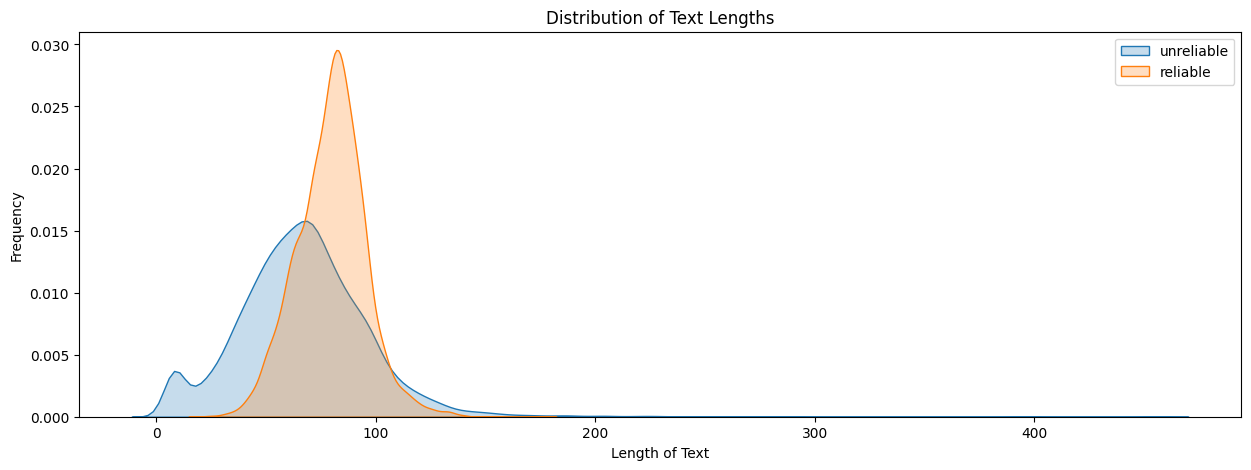

In [111]:
# let's see our Text length distribution
# unreliable tend to have shorter titles but have filled the nulls with no title
# reliable news tend to range between 50 - 100
plt.figure(figsize= (15, 5))
sns.kdeplot(data[data['label'] == 1]['title'].str.len(), fill= True, label= 'unreliable')
sns.kdeplot(data[data['label'] == 0]['title'].str.len(), fill= True, label= 'reliable')
plt.xlabel('Length of Text')
plt.ylabel('Frequency')
plt.title('Distribution of Text Lengths')
plt.legend()
plt.savefig('Fig/text_distribution.jpeg')
plt.show()

In [112]:
data['text'] = data['title'] + ' by ' + data['author']

In [113]:
# want to check if having emojis in the tile or name is a sign of being from an unreliable source
# since only two rows out of 10k have emoji i don't see a point in replacing all emojis for a word
# i can just remove the emojis as i will do for punctuation
_ = data.copy()
def contains_unicode_symbols(text):
    emoji_ranges = (
        (0x1F600, 0x1F64F),  # emoticons
        (0x1F300, 0x1F5FF),  # symbols & pictographs
        (0x1F680, 0x1F6FF),  # transport & map symbols
        (0x1F1E0, 0x1F1FF)   # flags (iOS)
    )
    
    for emoji_range in emoji_ranges:
        for char in text:
            if emoji_range[0] <= ord(char) <= emoji_range[1]:
                return True
    return False

_['has_emoji'] = _['text'].apply(contains_unicode_symbols)
_[_['has_emoji']]


,title,author,label,text,has_emoji
6517,Re: Michelle Obama calls for a ‘president who ...,MarciaTheMurkyMuse🌠 Variegated,1,Re: Michelle Obama calls for a ‘president who ...,True
10266,🚨Bill Clinton and Hillary Lolita Express Pedop...,Alex Ansary,1,🚨Bill Clinton and Hillary Lolita Express Pedop...,True


# Comparison between text preprocessing technique 

In [114]:
# cleans (removes symbols, punctuation, emojis, stopwords and stems the words) and tokenizes our textual data
stop_words = stopwords.words('english')
ss = SnowballStemmer(language='english')

def f_tokenizer(x):
    cleaned_text = re.sub(r'[^a-zA-Z0-9 ]+', ' ', x) # removes all the symbols, emojis, punctuation marks
    tokens = cleaned_text.split() # splits on whitespaces
    remove_stopwords = [ss.stem(word) for word in tokens if tokens not in stop_words] # removes stopwords and stemms them
    
    return remove_stopwords
    

In [115]:
# we can compare both to see if they perform the same or if tfidf performs better
cv_vect = CountVectorizer(tokenizer= f_tokenizer, max_features = 5000, token_pattern = None)
cv_trainset = cv_vect.fit_transform(data['text']).toarray()

tfidf_vect = TfidfVectorizer(tokenizer= f_tokenizer, max_features = 5000, token_pattern = None)
tfidf_trainset = tfidf_vect.fit_transform(data['text']).toarray()

In [214]:
# reduce the dimensionality of our data so we can be visualize it in a 2D chart.
from sklearn.decomposition import TruncatedSVD

lsa = TruncatedSVD(n_components=2)
cv_lsa_scores = lsa.fit_transform(cv_trainset)

tfidf_lsa_scores= lsa.fit_transform(tfidf_trainset)

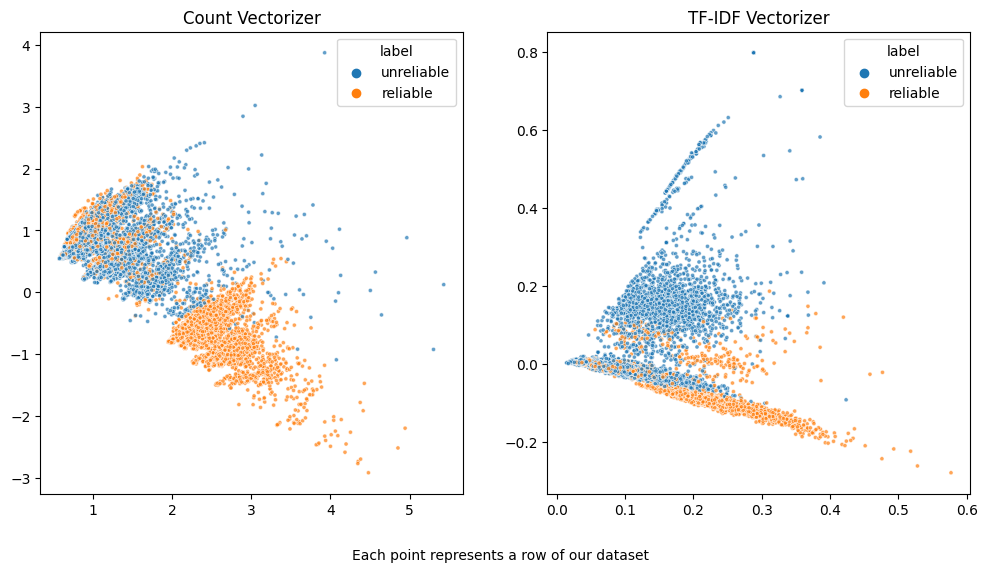

In [215]:
# in this case since there is such a visable difference between both labels in each method, they might perform similarly
# we are going to use tf-idf as our vectorizer
fig, ax = plt.subplots(1,2, figsize=(12, 6) )
mapping = {0: 'reliable', 1: 'unreliable'}
sns.scatterplot(x = cv_lsa_scores[:,0], y =cv_lsa_scores[:,1], hue= data['label'].map(mapping), alpha= 0.7, marker= '.', ax=ax[0])
ax[0].set_title('Count Vectorizer')
sns.scatterplot(x = tfidf_lsa_scores[:,0], y =tfidf_lsa_scores[:,1], hue= data['label'].map(mapping), alpha= 0.7, marker= '.', ax=ax[1])
ax[1].set_title('TF-IDF Vectorizer')
plt.text(-0.3,-0.5, 'Each point represents a row of our dataset')
plt.savefig('Fig/preprocessing_methods.jpeg', dpi= 300)
plt.show()

# Train Models

## Machine Learning

In [116]:
X_train, X_test, y_train, y_test = train_test_split(tfidf_trainset, 
                                                    data['label'], 
                                                    test_size= 0.33, 
                                                    random_state=0)

In [117]:
X_train.shape, y_train.shape

((13676, 5000), (13676,))

In [118]:
models = [(LogisticRegression(random_state= 0), "LR"), 
          (MultinomialNB(), 'NB'),
          (CalibratedClassifierCV(LinearSVC(random_state= 0)), "SVC"), 
          (RandomForestClassifier(random_state= 0 ,n_jobs= -1), "RF"), 
          (XGBClassifier(), "XGBoost")
          ]

In [119]:
metrics = defaultdict(dict)
cwd = Path.cwd()
sub_path = "models"

for model, model_name in models:
  print(f'Starting {model_name}')

  start = time.time()
  model.fit(X_train, y_train)
  end = time.time()

  seconds = round(end - start)
  print(f'finished {model_name} training in {seconds // 60:02d}:{seconds%60:02d}\n')

  print("Saving model ...")
  sample_dir = cwd / sub_path / model_name
  sample_dir.mkdir(parents=True, exist_ok=True)
  output = str(sample_dir) + ".joblib"
  joblib.dump(model, output)
  print("Computing metrics ...\n")

  size = os.stat(output).st_size / (1024 * 1024)

  pred_prob = model.predict_proba(X_test)
  y_pred = pred_prob.argmax(axis=1)
  fpr, tpr, thresholds = roc_curve(y_test, pred_prob[:,1])
  metrics[model_name] = {
                  'pred_proba': pred_prob,
                  'y_pred': y_pred,
                  'Accuracy': accuracy_score(y_test, y_pred), 
                  'Precision': precision_score(y_test, y_pred),
                  'Recall': recall_score(y_test, y_pred),
                  'F1 score': f1_score(y_test, y_pred),
                  'fpr': fpr,
                  'tpr': tpr,
                  'thresholds': thresholds,
                  'AOC Score': auc(fpr, tpr),
                  'Time Taken': seconds,
                  'Model Path': output,
                  'Size in MB': size
                  }
    
joblib.dump(dict(metrics), cwd / sub_path / "metrics.joblib")

Starting LR
finished LR training in 00:02

Saving model ...
Computing metrics ...

Starting NB
finished NB training in 00:00

Saving model ...
Computing metrics ...

Starting SVC
finished SVC training in 00:02

Saving model ...
Computing metrics ...

Starting RF
finished RF training in 00:09

Saving model ...
Computing metrics ...

Starting XGBoost
finished XGBoost training in 00:08

Saving model ...
Computing metrics ...



['/Users/goncalomoura/Documents/Data_science/Portfolio/Fake_news/models/metrics.joblib']

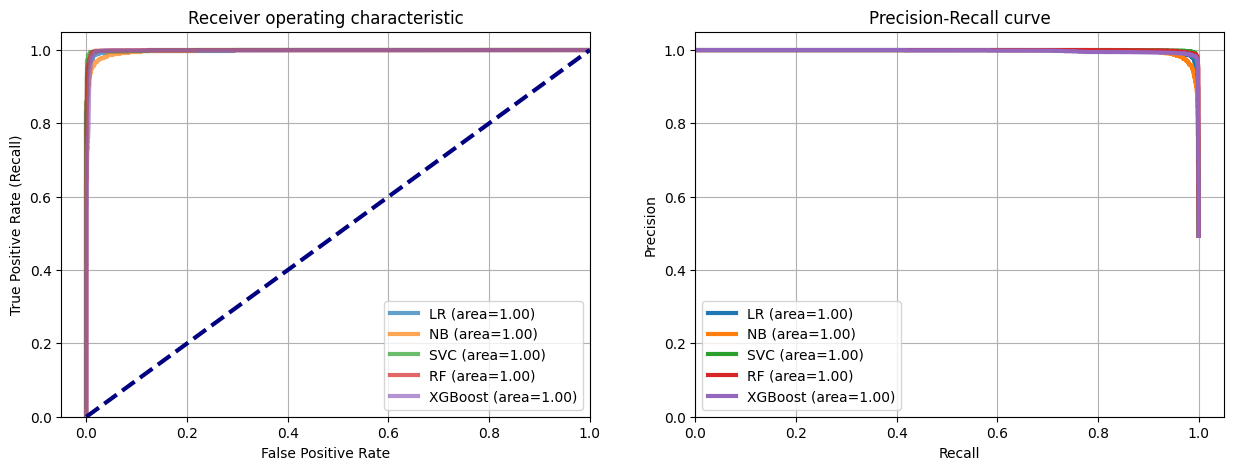

In [120]:
# PLOTTING ROC AND PRECISION-RECALL CURVE OF THE TRAINED MODELS

fig, ax = plt.subplots(nrows=1, ncols=2, figsize= (15,5))
## Plot roc
for name, info in metrics.items():
    ax[0].plot(info['fpr'], info['tpr'], lw=3 , alpha= .7, label='{0} (area={1:0.2f})'.format(name, round(info['AOC Score'], 2)))
ax[0].plot([0,1], [0,1], color='navy', lw=3, linestyle='--')
ax[0].set(xlim=[-0.05,1.0], ylim=[0.0,1.05], xlabel='False Positive Rate',
            ylabel="True Positive Rate (Recall)", title="Receiver operating characteristic")
ax[0].legend(loc="lower right")
ax[0].grid(True)

## Plot precision-recall curve
for name, info in metrics.items():
    precision, recall, thresholds = precision_recall_curve(y_test, info['pred_proba'][:,1])
    ax[1].plot(recall, precision, lw=3, label='{0} (area={1:0.2f})'.format(name, auc(recall, precision)))
ax[1].set(xlim=[0.0,1.05], ylim=[0.0,1.05], xlabel='Recall', ylabel="Precision", title="Precision-Recall curve")
ax[1].legend(loc="best")
ax[1].grid(True)
plt.show()

In [121]:
lst = []
for name, info in metrics.items():
  _ = {key: value for key, value in info.items() if key not in ['pred_proba', 'y_pred', 'fpr', 'tpr', 'thresholds', 'Model Path']}
  _.update({"model": name})
  lst.append(_)

metrics_table = pd.DataFrame(lst).set_index(['model'])
metrics_table

,Accuracy,Precision,Recall,F1 score,AOC Score,Time Taken,Size in MB
model,,,,,,,
LR,0.981888,0.972813,0.990969,0.981807,0.998094,2,0.038970
NB,0.966894,0.991125,0.941300,0.965570,0.997152,0,0.153342
SVC,0.992280,0.993064,0.991270,0.992166,0.999050,2,0.193578
RF,0.990499,0.983383,0.997592,0.990436,0.999297,9,15.665917
XGBoost,0.985897,0.974978,0.996990,0.985861,0.997854,8,0.130797


In [122]:
# since we don't have specific requirements for what model we need we can choose the simplest one (LR in this case) 
metrics_table.loc['LR']

Accuracy      0.981888
Precision     0.972813
Recall        0.990969
F1 score      0.981807
AOC Score     0.998094
Time Taken    2.000000
Size in MB    0.038970
Name: LR, dtype: float64

              precision    recall  f1-score   support

           0       0.99      0.97      0.98      3414
           1       0.97      0.99      0.98      3322

    accuracy                           0.98      6736
   macro avg       0.98      0.98      0.98      6736
weighted avg       0.98      0.98      0.98      6736



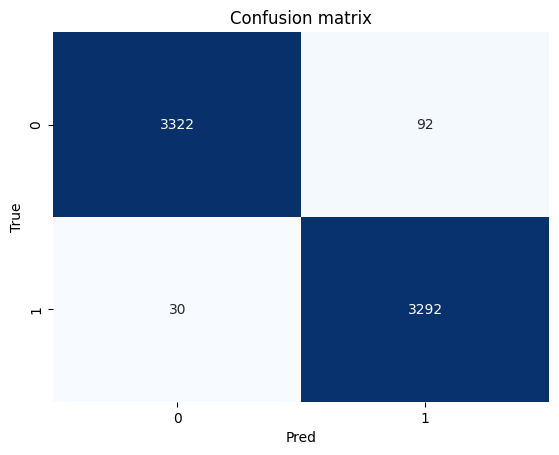

In [123]:
# Let's plot its confusion matrix and classification report
print(classification_report(y_test, metrics['LR']['y_pred']))

cm = confusion_matrix(y_test, metrics['LR']['y_pred'])
fig, ax = plt.subplots()
sns.heatmap(cm, annot=True, fmt='d', ax=ax, cmap=plt.cm.Blues, cbar=False)
ax.set(xlabel="Pred", ylabel="True", title="Confusion matrix")
plt.show()

### Model explanability

In [124]:
import shap
np.random.seed(101)
shap.initjs()

In [125]:
model = joblib.load('models/LR.joblib')

In [130]:
explainer = shap.Explainer(model, X_train, feature_names=tfidf_vect.get_feature_names_out())
shap_values = explainer(X_test)

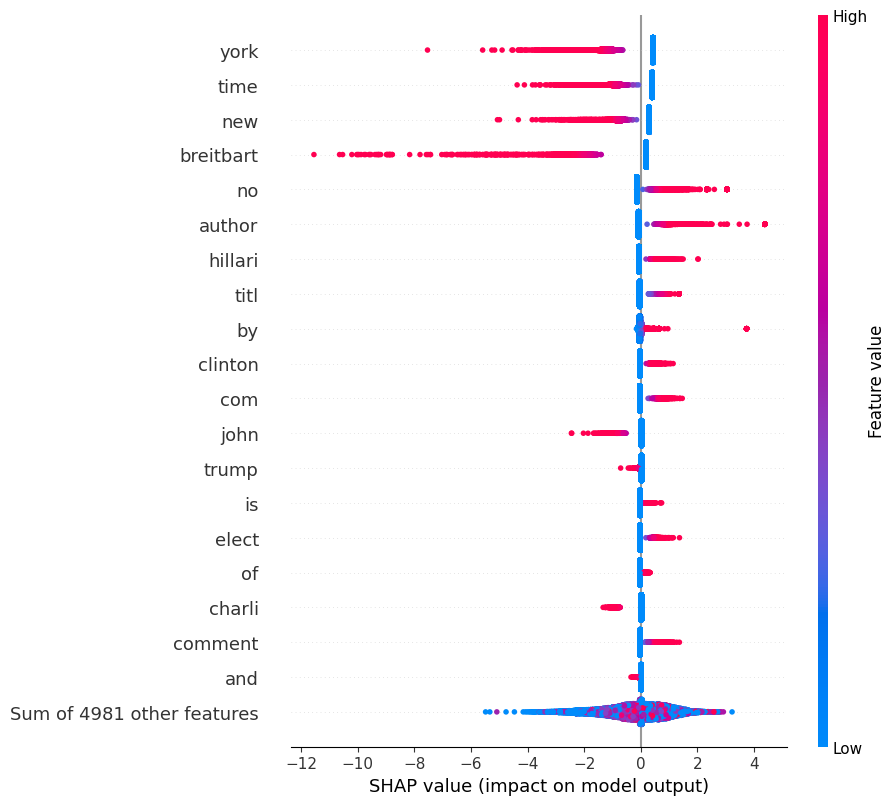

In [257]:
# in our use case low shap value means that more rows with that word are reliable 
# and the higher our shap value more rows with that words are unreliable
# from this we can see that new york time or breitbart (which seems to be a signature before the author name) as a big influence on our models decision
# as well as no author or no title, like we previously had seen the majority of missing title/author come from unreliable sources

shap.plots.beeswarm(shap_values, max_display= 20, show=False)

In [36]:
# it's present in the title that is why we haven't seen in before
print('Example: ', data[data['title'].str.contains('New York Times')]['text'].iloc[0])
data[data['title'].str.contains('New York Times')]['label'].value_counts()

Example:  Benoît Hamon Wins French Socialist Party’s Presidential Nomination - The New York Times by Alissa J. Rubin


label
0    6229
1      12
Name: count, dtype: int64

In [37]:
# it's present in the title that is why we haven't seen in before
print('Example: ', data[data['title'].str.contains('Breitbart')]['text'].iloc[4])
data[data['title'].str.contains('Breitbart')]['label'].value_counts()

Example:  EXCLUSIVE: Islamic State Supporters Vow to ‘Shake’ the West Following Manchester Terrorist Massacre - Breitbart by Aaron Klein and Ali Waked


label
0    2352
1       4
Name: count, dtype: int64

In [38]:
data[data['title'].str.contains('Breitbart')]['text']

1        FLYNN: Hillary Clinton, Big Woman on Campus - ...
5        Jackie Mason: Hollywood Would Love Trump if He...
19       Chuck Todd: ’BuzzFeed Did Donald Trump a Polit...
22       Rob Reiner: Trump Is ’Mentally Unstable’ - Bre...
26       EXCLUSIVE: Islamic State Supporters Vow to ‘Sh...
                               ...                        
20759    Coulter Calls Out ’Beta Males’ for Threatening...
20765    NFL Preview: Championship Match-Ups Prove Team...
20787    Sally Yates Won’t Say If Trump Was Wiretapped ...
20789    Sen. McConnell: The Supreme Court Vacancy Was ...
20794    Trump: Putin ’Very Smart’ to Not Retaliate ove...
Name: text, Length: 2356, dtype: object

EXCLUSIVE: Islamic State Supporters Vow to ‘Shake’ the West Following Manchester Terrorist Massacre - Breitbart by Aaron Klein and Ali Waked


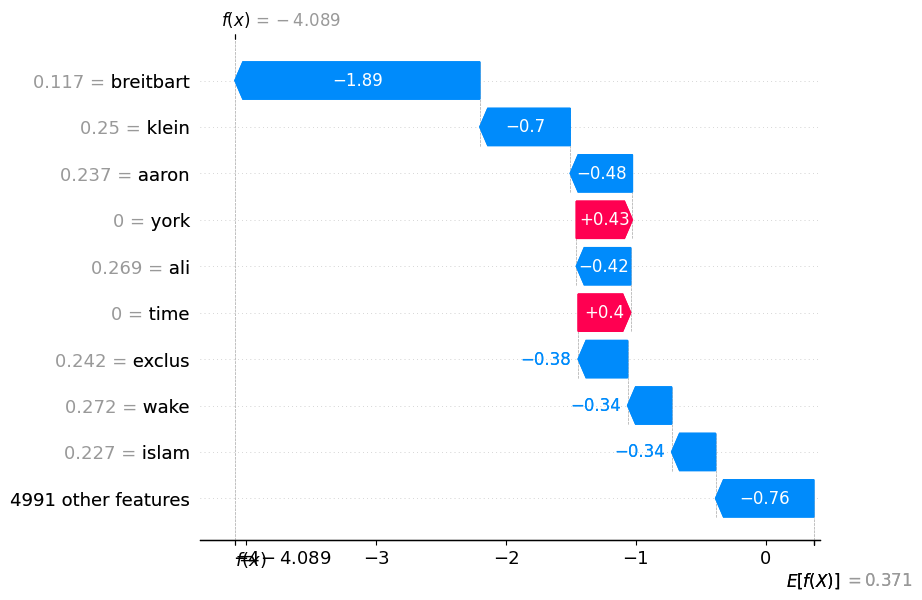

In [95]:
ind = 26
print(data['text'].iloc[ind])

shap.plots.waterfall(shap_values[ind])
plt.savefig('Fig/shap_waterfall.jpeg', dpi=300)

In [69]:
shap.plots.force(shap_values[ind])

In [70]:
print("Unreliable" if data['label'].iloc[ind] else "Reliable", "News:")
print(data['text'].iloc[ind])

Reliable News:
EXCLUSIVE: Islamic State Supporters Vow to ‘Shake’ the West Following Manchester Terrorist Massacre - Breitbart by Aaron Klein and Ali Waked


### Packaging Our Model: Machine Learning Pipeline

In [71]:
import pandas as pd
import numpy as np

import re
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer

import joblib

from sklearn.base import TransformerMixin, BaseEstimator
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression

from sklearn.pipeline import Pipeline

class Preprocessing_text(BaseEstimator, TransformerMixin):
    
    def fit(self, X, y = None):
        return self
        
    def transform(self, X):
        
        if isinstance(X, list):
            return X
        
        X = X.copy()
        
        X = X.fillna({'title': 'no title', 'author': 'no author'})
        X['text'] = X['title'] + ' by ' + X['author']
        
        return X['text']

# cleans (removes symbols, punctuation, emojis, stopwords and stems the words) and tokenizes our textual data
stop_words = stopwords.words('english')
ss = SnowballStemmer(language='english')

def f_tokenizer(x):
    cleaned_text = re.sub(r'[^a-zA-Z0-9 ]+', ' ', x) # removes all the symbols, emojis, punctuation marks
    tokens = cleaned_text.split() # splits on whitespaces
    remove_stopwords = [ss.stem(word) for word in tokens if tokens not in stop_words] # removes stopwords and stemms them
    
    return remove_stopwords


pipe = Pipeline(steps = [('preprocessing', Preprocessing_text()),
                         ('tfidf', TfidfVectorizer(tokenizer= f_tokenizer, max_features= 5000)), 
                         ('estimator', LogisticRegression(random_state= 0))])

In [72]:
data = pd.read_csv(r'Database/train.csv')[['title', 'author', 'label']].drop_duplicates()
X_train = data[['title', 'author']]
y_train = data['label']
X_train.shape, y_train.shape

((20412, 2), (20412,))

In [73]:
pipe.fit(X_train, y_train)

Pipeline(steps=[('preprocessing', Preprocessing_text()),
                ('tfidf',
                 TfidfVectorizer(max_features=5000,
                                 tokenizer=<function f_tokenizer at 0x7fc329bd3e50>)),
                ('estimator', LogisticRegression(random_state=0))])

In [74]:
# examples use of the pipeline to do the preprocessing and predictions of a row
pipe.predict(pd.DataFrame({"title": ['Donald Trump was caugth naked in the white house'],
                           "author": ['donald trump']}))

array([1])

In [75]:
# we can also feed it a list if we want to where each element is a row.
pipe.predict(['Donald Trump was caugth naked in the white house by donald trump',
              'House Dem Aide: We Didn’t Even See Comey’s Letter Until Jason Chaffetz Tweeted It by Darrell Lucus',
              'FLYNN: Hillary Clinton, Big Woman on Campus - Breitbart by Daniel J. Flynn'])

array([1, 1, 0])

## Deep Learning

In [22]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Dense, Input, GlobalMaxPooling1D
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Embedding
from tensorflow.keras.models import Model

In [39]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(data['text'])

sequences = tokenizer.texts_to_sequences(data['text'])

padded_sequences = pad_sequences(sequences)
padded_sequences

array([[   0,    0,    0, ...,    1, 3385, 3633],
       [   0,    0,    0, ...,   85,  112,  770],
       [   0,    0,    0, ...,    1,  667,   44],
       ...,
       [   0,    0,    0, ...,    7,  482, 2224],
       [   0,    0,    0, ...,    1,  199,  462],
       [   0,    0,    0, ...,    1,   75, 1941]], dtype=int32)

In [40]:
# divide into train and test

X_train, X_test, y_train, y_test = train_test_split(padded_sequences, data['label'], test_size= 0.2, random_state= 0)

In [43]:
X_train.shape, X_test.shape

((16329, 73), (4083, 73))

In [46]:
y_train.shape, y_test.shape

((16329,), (4083,))

In [47]:
# dimension of my input
T = padded_sequences.shape[1]
T

73

In [48]:
# Choose embedding dimensionality
D = 20 # this is a hyper parameter, we can choose any word vector size that we want

V = len(tokenizer.word_index) # number of unique words

In [66]:
# Input layer
i = Input(shape=(T,))  # input layer takes in sequences of integers, so shape is T

# Embedding layer
x = Embedding(V + 1, D)(i) # This takes in sequences of integers and returns sequences of word vectors
# This will be an N * T * D array
# we want size of embedding to (V + 1) x D, because first word index starts from 1 and not 0
# there is no 0 in the word index that was added with padding so we do V + 1

#  First CNN layer
x = Conv1D(32, 3, activation='relu')(x) # we will extract 32 features and each of the 32 features have 3 values
x = MaxPooling1D(3)(x) # this will slide over the feature maps with the 3 adjecent values and then it will stride 3 values so not overlaping any of the values 

# Second CNN layer
x = Conv1D(64, 3, activation='relu')(x) # all the negative values will be desactivated since we are using relu activation function
x = MaxPooling1D(3)(x)

# Third CNN layer
x = Conv1D(128, 3, activation='relu')(x)
x = GlobalMaxPooling1D()(x)

# Dense layer y = w1*x1 + w2*x2 + ... + w128*x128 reduces it to a single value 
# between 0 and 1 for each detection that passes through the sigmoid function
x = Dense(1, activation='sigmoid')(x)

model = Model(i, x)

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [67]:
# Train the model
history = model.fit(x=X_train, y=y_train, epochs=5, validation_data=(X_test, y_test))

Epoch 1/5
511/511 [==============================] - 3s 5ms/step - loss: 0.2243 - accuracy: 0.8955 - val_loss: 0.1323 - val_accuracy: 0.9469
Epoch 2/5
511/511 [==============================] - 3s 6ms/step - loss: 0.0444 - accuracy: 0.9850 - val_loss: 0.1305 - val_accuracy: 0.9544
Epoch 3/5
511/511 [==============================] - 3s 5ms/step - loss: 0.0067 - accuracy: 0.9980 - val_loss: 0.1657 - val_accuracy: 0.9549
Epoch 4/5
511/511 [==============================] - 3s 6ms/step - loss: 7.7521e-04 - accuracy: 0.9999 - val_loss: 0.1898 - val_accuracy: 0.9527
Epoch 5/5
511/511 [==============================] - 3s 5ms/step - loss: 1.1315e-04 - accuracy: 1.0000 - val_loss: 0.2066 - val_accuracy: 0.9525


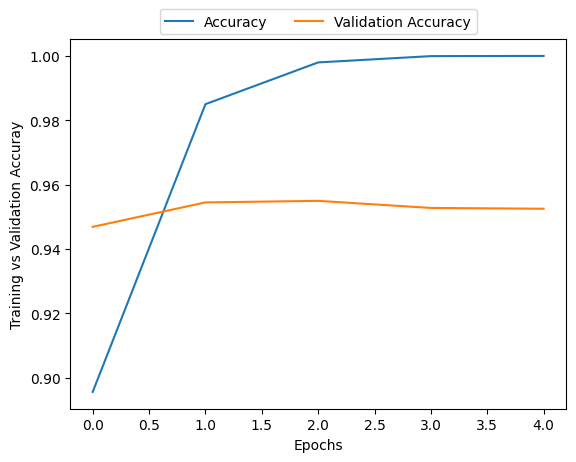

In [68]:
plt.plot(history.history['accuracy'], label = 'Accuracy')
plt.plot(history.history['val_accuracy'], label = 'Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Training vs Validation Accuray')
plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.1), ncol=2)
plt.show()

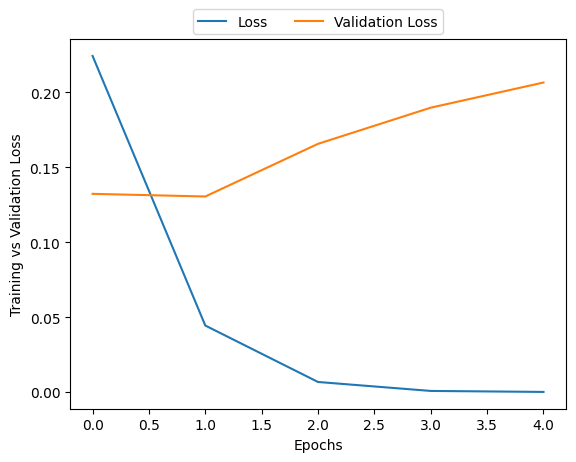

In [69]:
plt.plot(history.history['loss'], label = 'Loss')
plt.plot(history.history['val_loss'], label = 'Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Training vs Validation Loss')
plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.1), ncol=2)
plt.show()

In [78]:
# Let's predict on the same examples that we used before in our machine learning pipeline
new_sequences = tokenizer.texts_to_sequences(['Donald Trump was caugth naked in the white house by donald trump',
                                              'House Dem Aide: We Didn’t Even See Comey’s Letter Until Jason Chaffetz Tweeted It by Darrell Lucus',
                                              'FLYNN: Hillary Clinton, Big Woman on Campus - Breitbart by Daniel J. Flynn'])
padded_sequences = pad_sequences(new_sequences, maxlen = 73)

predictions = model.predict(padded_sequences)

# as you can see we get the same results
np.where(predictions >= 0.5, 1, 0)

INFO:tensorflow:Assets written to: my_model/assets


INFO:tensorflow:Assets written to: my_model/assets


1/1 [==============================] - 0s 46ms/step


array([[1],
       [1],
       [0]])